In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [49]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [50]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Temperature/Satkhira.csv')
#the daily dataset
print(df.shape)
df.head()

(792, 4)


,DATE,Max Temp,Min Temp,MEAN
0,1948-01-31,29.4,12.2,20.80
1,1948-02-29,33.4,15.6,24.50
2,1948-03-31,36.3,20.5,28.40
3,1948-04-30,35.6,24.2,29.90
4,1948-05-31,37.3,25.4,31.35


In [51]:
#checking types
df.pop('Max Temp')
df.pop('Min Temp')
df.dtypes

DATE     object
MEAN    float64
dtype: object

Data Preprocessing
---------

In [52]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

           DATE   MEAN
0    1948-01-31  20.80
1    1948-02-29  24.50
2    1948-03-31  28.40
3    1948-04-30  29.90
4    1948-05-31  31.35
..          ...    ...
787  2013-08-31  30.30
788  2013-09-30  31.10
789  2013-10-31  29.50
790  2013-11-30  24.95
791  2013-12-31  21.50

[792 rows x 2 columns]


In [53]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [54]:
df.head()

,DATE,MEAN
0,1948-01-31,20.80
1,1948-02-29,24.50
2,1948-03-31,28.40
3,1948-04-30,29.90
4,1948-05-31,31.35


In [55]:
df.tail()

,DATE,MEAN
787,2013-08-31,30.30
788,2013-09-30,31.10
789,2013-10-31,29.50
790,2013-11-30,24.95
791,2013-12-31,21.50


In [56]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
#df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,MEAN
DATE,
1948-01-31,20.80
1948-02-29,24.50
1948-03-31,28.40
1948-04-30,29.90
1948-05-31,31.35


In [57]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Satkhira_monthly.csv")

(792, 1)


In [58]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1948-01-31 00:00:00
End Date: 2013-12-31 00:00:00
Total month: 792
Total year: 66


Data Visulalization
----------

About Data

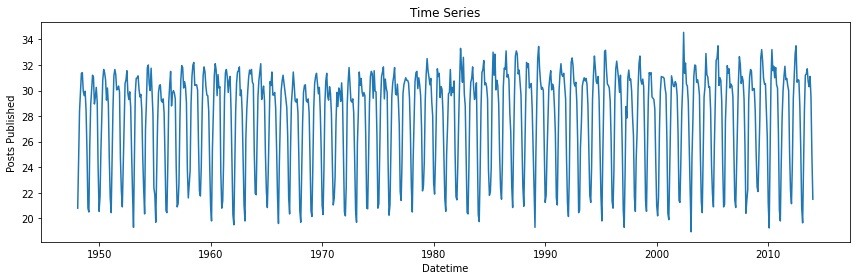

In [59]:
# 7.Plotting the time series
monthly['MEAN'] = monthly['MEAN'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(696, 1), Validation=(96, 1)


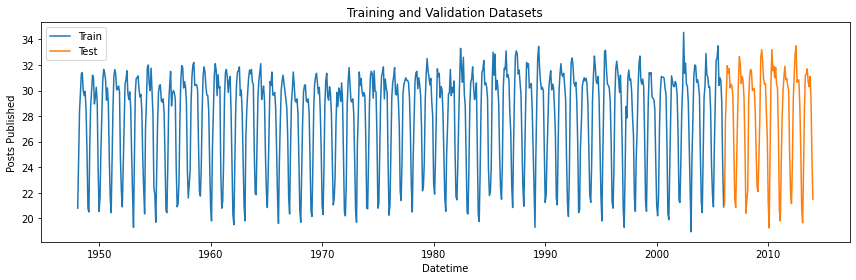

In [60]:
train = monthly.loc[:'2005-12-31']
valid = monthly.loc['2006-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [61]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [62]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

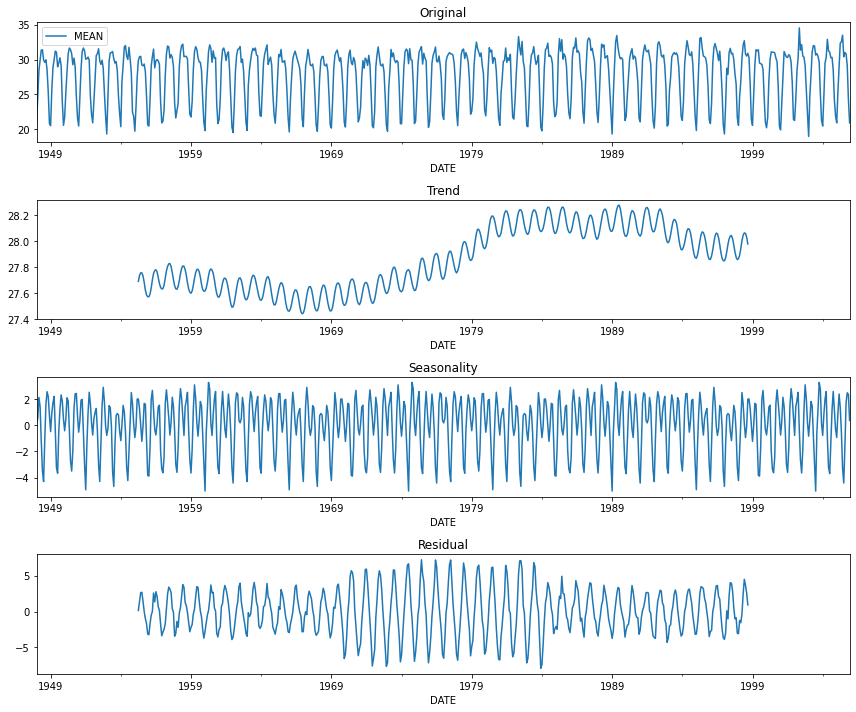

In [63]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [64]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

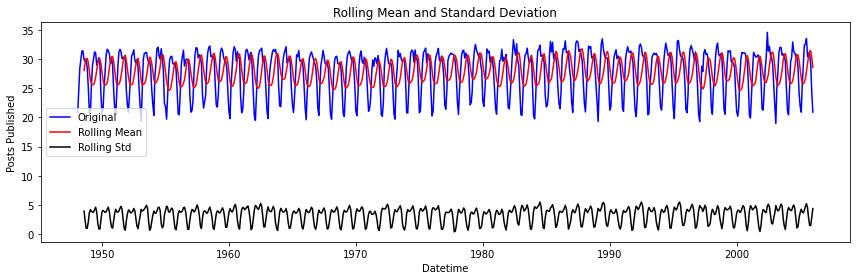

Results of Dickey-Fuller Test:
Test Statistic                  -4.519115
P-Value                          0.000182
#Lags Used                      15.000000
Number of Observations Used    680.000000
Critical Value (1%)             -3.440003
Critical Value (5%)             -2.865800
Critical Value (10%)            -2.569038
dtype: float64


In [65]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [66]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [67]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   MEAN   No. Observations:                  696
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1181.698
Date:                Mon, 07 Nov 2022   AIC                           2381.396
Time:                        12:35:18   BIC                           2422.291
Sample:                    01-31-1948   HQIC                          2397.210
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8638      0.035     24.907      0.000       0.796       0.932
ar.L2         -0.3229      0.050     -6.502      0.000      -0.420      -0.226
ar.L3         -0.3498      0.051     -6.802      0.0

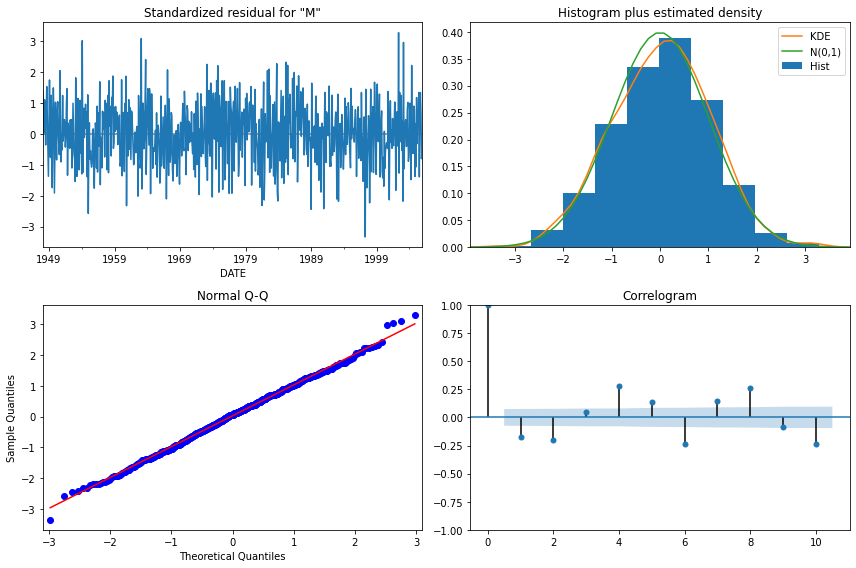

In [68]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

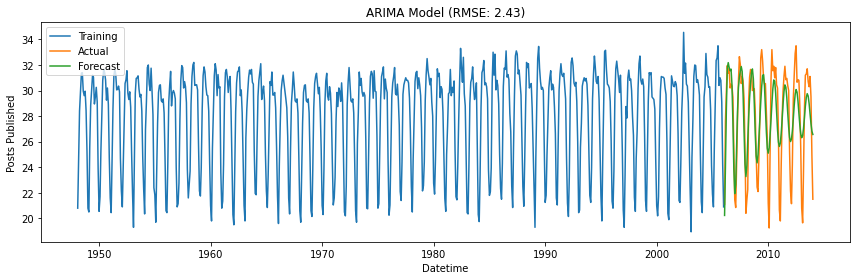

In [69]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [70]:
#Values of ARIMA prediction
print(forecast_arima)

2006-01-31    20.232681
2006-02-28    23.996337
2006-03-31    28.603701
2006-04-30    31.735338
2006-05-31    32.183082
                ...    
2013-08-31    28.985847
2013-09-30    28.195923
2013-10-31    27.411228
2013-11-30    26.822135
2013-12-31    26.565598
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [71]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  2.4303109078863305


---------------------

SARIMAX MODEL

In [72]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [73]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               MEAN   No. Observations:                  696
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                -800.378
Date:                            Mon, 07 Nov 2022   AIC                           1634.757
Time:                                    12:38:06   BIC                           1711.707
Sample:                                01-31-1948   HQIC                          1664.536
                                     - 12-31-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1882      0.043      4.387      0.000       0.104       0.272
ar.L2          0.1261      0.041   

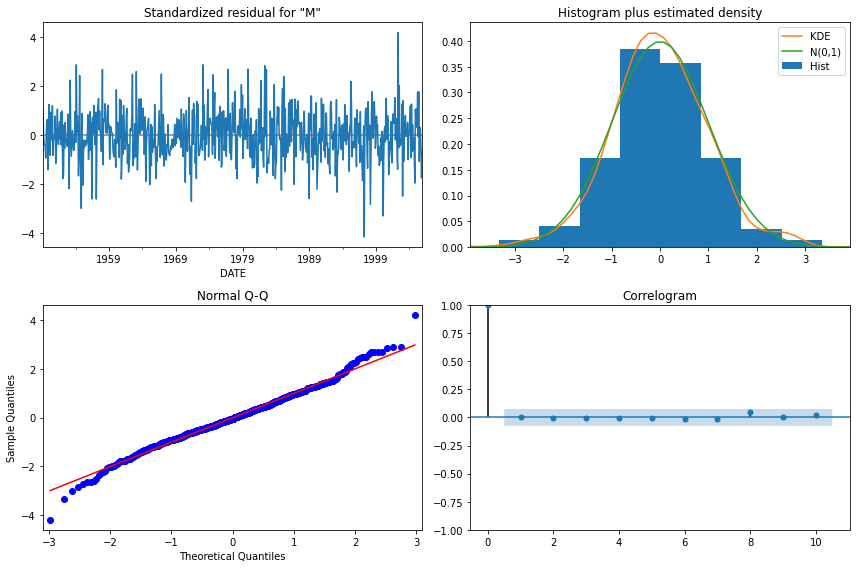

In [74]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

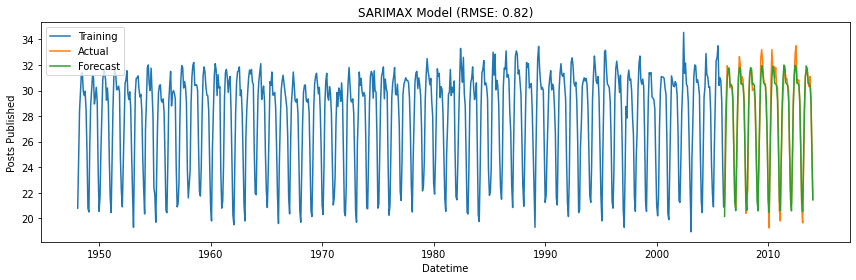

In [75]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [76]:
#Value of SARIMA prediction
print(forecast_sarimax)

2006-01-31    20.159852
2006-02-28    24.371534
2006-03-31    28.613931
2006-04-30    30.966276
2006-05-31    31.735124
                ...    
2013-08-31    30.537202
2013-09-30    30.381290
2013-10-31    29.177885
2013-11-30    25.461953
2013-12-31    21.445657
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [77]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.818900878625703


-----------------------

PROPHET

In [78]:
#Reading monthly data 
df= pd.read_csv('Satkhira_monthly.csv')

In [79]:

#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1948-01-31,20.80
1,1948-02-29,24.50
2,1948-03-31,28.40
3,1948-04-30,29.90
4,1948-05-31,31.35


In [80]:
#prophet model Implement
prophet_model = Prophet()

In [81]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpevflfspt/ldw4lqic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpevflfspt/i8rqcvx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41708', 'data', 'file=/tmp/tmpevflfspt/ldw4lqic.json', 'init=/tmp/tmpevflfspt/i8rqcvx9.json', 'output', 'file=/tmp/tmpevflfspt/prophet_model0gpd5iim/prophet_model-20221107123807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [82]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 11, freq='M')
print(prophet_forecast_date)

            ds
0   1948-01-31
1   1948-02-29
2   1948-03-31
3   1948-04-30
4   1948-05-31
..         ...
919 2024-08-31
920 2024-09-30
921 2024-10-31
922 2024-11-30
923 2024-12-31

[924 rows x 1 columns]


In [83]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1948-01-31,27.601926,19.384277,21.281962,27.601926,27.601926,-7.271978,-7.271978,-7.271978,-7.271978,-7.271978,-7.271978,0.0,0.0,0.0,20.329948
1,1948-02-29,27.602264,22.959831,24.872126,27.602264,27.602264,-3.665134,-3.665134,-3.665134,-3.665134,-3.665134,-3.665134,0.0,0.0,0.0,23.937129
2,1948-03-31,27.602624,27.500410,29.417281,27.602624,27.602624,0.929284,0.929284,0.929284,0.929284,0.929284,0.929284,0.0,0.0,0.0,28.531908
3,1948-04-30,27.602974,29.846027,31.872604,27.602974,27.602974,3.190094,3.190094,3.190094,3.190094,3.190094,3.190094,0.0,0.0,0.0,30.793068
4,1948-05-31,27.603335,30.470368,32.346093,27.603335,27.603335,3.797230,3.797230,3.797230,3.797230,3.797230,3.797230,0.0,0.0,0.0,31.400565


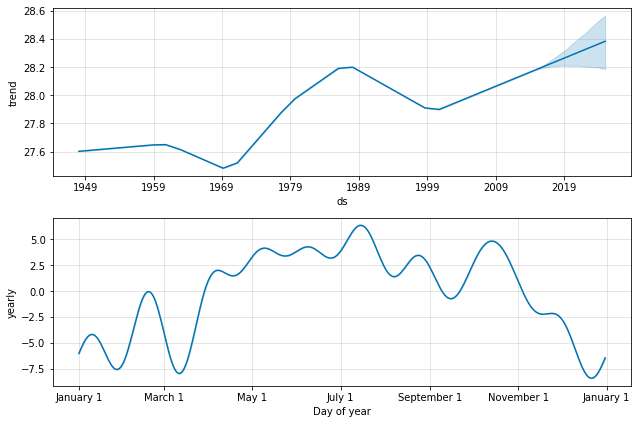

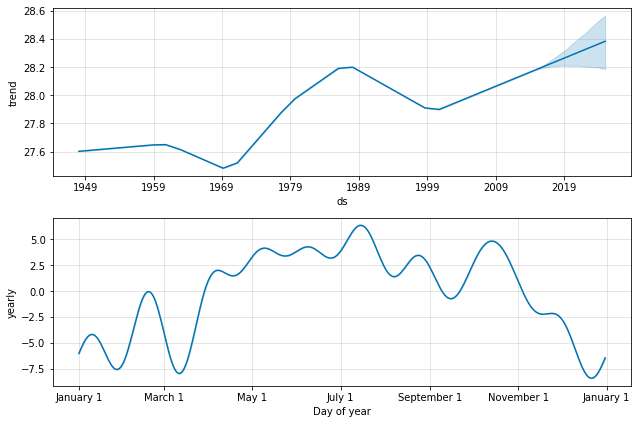

In [84]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [85]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1948-01-31  20.329948
1948-02-29  23.937129
1948-03-31  28.531908
1948-04-30  30.793068
1948-05-31  31.400565
...               ...
2024-08-31  30.803170
2024-09-30  30.888064
2024-10-31  29.507094
2024-11-30  25.795800
2024-12-31  22.031208

[924 rows x 1 columns]


In [86]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1948-01-31    20.329948
1948-02-29    23.937129
1948-03-31    28.531908
1948-04-30    30.793068
1948-05-31    31.400565
                ...    
2024-08-31    30.803170
2024-09-30    30.888064
2024-10-31    29.507094
2024-11-30    25.795800
2024-12-31    22.031208
Name: yhat, Length: 924, dtype: float64


In [87]:
print(valid)

             MEAN
DATE             
2006-01-31  21.10
2006-02-28  27.60
2006-03-31  29.90
2006-04-30  31.95
2006-05-31  31.35
...           ...
2013-08-31  30.30
2013-09-30  31.10
2013-10-31  29.50
2013-11-30  24.95
2013-12-31  21.50

[96 rows x 1 columns]


In [88]:
forecast_prophet_valid=full_forecast_prophet['2006-01-31':'2013-12-31']

In [89]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.7966231803488687


-----------------

MODEL Comparison
----------

Testing

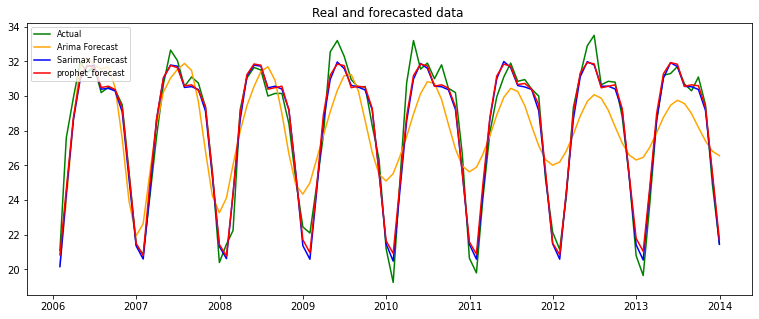

In [90]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

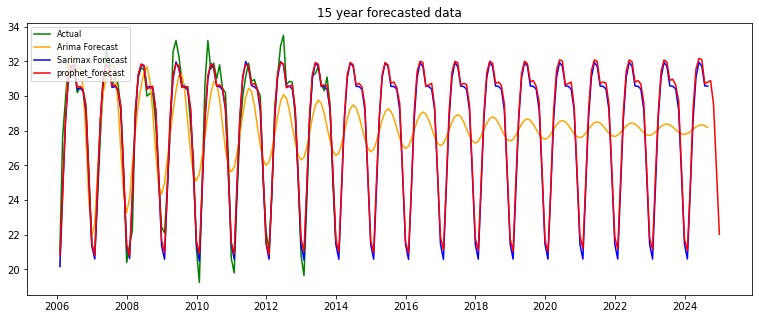

In [91]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+128)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+128)
forecast_10_prophet=full_forecast_prophet['2006-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

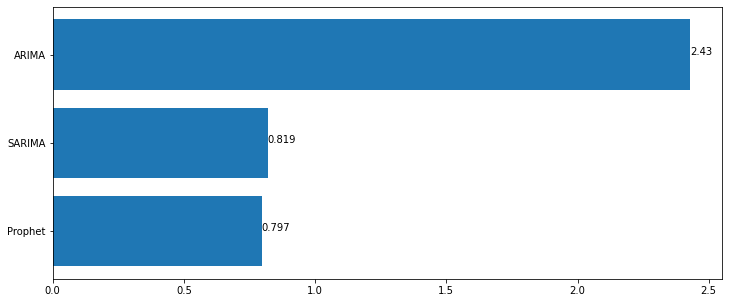

In [92]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [93]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :24-11-30

Choose the correct date according to the mentioned format


In [94]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Satkhira-monthly_merged.csv")